In [85]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr

In [86]:
papers_df = pd.read_csv("papers_and_authors.csv")
edges_df = pd.read_csv("edges.csv")
papers_df.columns = [c.strip() for c in papers_df.columns]
edges_df.columns = [c.strip() for c in edges_df.columns]
papers_df['abstract'] = papers_df['abstract'].fillna("")
papers_df['venue'] = papers_df.get('venue', 'Unknown').fillna('Unknown')

# Map IDs to index
id_to_idx = {str(pid): i for i, pid in enumerate(papers_df['paper_id'])}

print("Computing NLP Embeddings")
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(papers_df['abstract'])

print("Computing TF-IDF similarity matrix")
similarity_matrix = cosine_similarity(tfidf_matrix)

Computing NLP Embeddings
Computing TF-IDF similarity matrix


In [87]:
G = nx.DiGraph()

# Add Nodes
for _, row in papers_df.iterrows():
    paper_id = str(row["paper_id"])
    try: 
        year = int(float(row["year"]))
    except: 
        year = 0
    G.add_node(paper_id, title=row["title"], year=year, abstract=row["abstract"])

# Add Edges
for _, row in edges_df.iterrows():
    source = str(row['source'])
    target = str(row['target'])
    if source in G.nodes and target in G.nodes:
        G.add_edge(source,target)
 
print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph built: 500 nodes, 868 edges


In [88]:
def Temporal_Weights(G, lambda_decay=0.1):
    years = [data["year"] for _, data in G.nodes(data=True) if data.get("year", 0) > 0]
    Y_max = max(years) if years else 2025
    weights = {}
    for n, data in G.nodes(data=True):
        y = data.get("year" , Y_max)
        weights[n] = math.exp(-lambda_decay * (Y_max - y))
    return weights

In [89]:
def PageRank_Temporal(G, damping_factor=0.85, temporal_decay= 0.1, tolerance=1e-6, max_iterations=1000):
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    PR = {n : 1 / N for n in nodes}
    temporal_weights = Temporal_Weights(G,temporal_decay)
    out_degree = {n : G.out_degree(n) for n in nodes}
    differences = []

    for iter in range(max_iterations):
        PR_new = {}
        dangling_rank = sum(PR[n] for n in nodes if out_degree[n] == 0)

        for n in nodes:
            rank_sum = 0.0
            for m in G.predecessors(n):
                if out_degree[m] > 0:
                    rank_sum += (PR[m] / out_degree[m])
            rank_sum += dangling_rank / N
            PR_new[n] = (1 - damping_factor) * temporal_weights[n] + damping_factor * rank_sum

        diff = sum(abs(PR_new[n] - PR[n]) for n in nodes)
        differences.append(diff)
        PR = PR_new

        if diff < tolerance :
            print(f"Temporal PageRank converged after {iter + 1} iterations")
            break
            
    return PR , differences , iter + 1

In [90]:
def ContentAware_PageRank(G,damping_factor=0.85, temporal_decay=0.1, tolerance = 1e-6 , max_iter=100,similarity_matrix=similarity_matrix,id_to_idx=id_to_idx):
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    PR = {n: 1/N for n in nodes}
    
    temp_weights = Temporal_Weights(G, temporal_decay)
    
    # Precompute outgoing similarity sums
    out_similarity_sum = {}
    for m in nodes:
        total = 0.0
        if m in id_to_idx:
            for n in G.successors(m):
                if n in id_to_idx:
                    total += similarity_matrix[id_to_idx[m]][id_to_idx[n]]
        out_similarity_sum[m] = total

    differences = []

    for it in range(max_iter):
        PR_new = {}
        dangling_sum = sum(PR[n] for n in nodes if out_similarity_sum[n] == 0)
        
        for n in nodes:
            rank_sum = 0.0
            # Incoming edges m -> n
            for m in G.predecessors(n):
                if m in id_to_idx and n in id_to_idx and out_similarity_sum[m] > 0:
                    similarity = similarity_matrix[id_to_idx[m]][id_to_idx[n]]
                    rank_sum += PR[m] * (similarity / out_similarity_sum[m])
            
            rank_sum += dangling_sum / N
            
            PR_new[n] = (1 - damping_factor) * temp_weights[n] + damping_factor * rank_sum
            
        diff = sum(abs(PR_new[n] - PR[n]) for n in nodes)
        differences.append(diff)
        PR = PR_new

        if diff < tolerance:
            print(f"Content Aware PageRank converged after {it+1} iterations")
            break
            
    return PR , differences, it + 1

In [91]:
def Analysis_Temporal(G,damping_factor,temporal_decay):
    PR, Differences, iterations = PageRank_Temporal(G,damping_factor,temporal_decay)
    plt.plot(np.arange(0, iterations), Differences)
    plt.xlabel("Iterations")
    plt.ylabel("Residual")
    plt.title(f"PageRank Convergence (α = {damping_factor} and λ = {temporal_decay})")
    plt.show()
    top_papers = sorted(PR.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nTop 10 papers by Temporal PageRank (alpha = {damping_factor} and λ = {temporal_decay}):")
    for pid, score in top_papers:
        node = G.nodes[pid]
        print(f"{pid[:8]} ({node.get('year','NA')}) - {node.get('title','')[:60]}... | Score: {score:.4f}")

    top_nodes = [pid for pid, _ in top_papers]

    node_sizes = [40 for _ in G.nodes()]      
    node_colors = ["skyblue" for _ in G.nodes()]   

    pos = nx.spring_layout(G, seed=42, k=0.6, iterations=100)

    plt.figure(figsize=(5, 5))

    nx.draw_networkx(
        G,
        pos,
        with_labels=False,
        node_size=node_sizes,
        node_color=node_colors,
        edge_color="gray",
        alpha=0.5,
        arrowsize=8,
    )
    
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=top_nodes,
        node_size=200,
        node_color="white",              
        edgecolors="darkred",            
        linewidths=2.5,                  
    )
    
    for n in top_nodes:
        x, y = pos[n]
        plt.text(
            x,
            y + 0.025,
            G.nodes[n]["title"][:25] + "...",
            fontsize=9,
            color="darkred",
            ha="center",
            fontweight="bold",
            bbox=dict(
                facecolor="white",
                alpha=0.7,
                edgecolor="darkred",
                boxstyle="round,pad=0.2"
            )
        )

    plt.title(
        f"Temporal PageRank (α={damping_factor}, λ={temporal_decay})",
        fontsize=10
    )
    plt.axis("off")
    plt.margins(0.05)
    plt.tight_layout()
    plt.savefig(f"Temporal_PageRank(α={damping_factor}_λ={temporal_decay}).png")
    plt.show()

    return PR

In [92]:
def Analysis_ContentAware(G,damping_factor,temporal_decay):
    PR, Differences, iterations = ContentAware_PageRank(G,damping_factor=damping_factor,temporal_decay=temporal_decay)
    plt.plot(np.arange(0, iterations), Differences)
    plt.xlabel("Iterations")
    plt.ylabel("Residual")
    plt.title(f"Content Aware PageRank Convergence (α = {damping_factor} and λ = {temporal_decay})")
    plt.show()
    top_papers = sorted(PR.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nTop 10 papers by Content Aware Temporal PageRank (alpha = {damping_factor} and λ = {temporal_decay}):")
    for pid, score in top_papers:
        node = G.nodes[pid]
        print(f"{pid[:8]} ({node.get('year','NA')}) - {node.get('title','')[:60]}... | Score: {score:.4f}")

    top_nodes = [pid for pid, _ in top_papers]

    node_sizes = [40 for _ in G.nodes()]      
    node_colors = ["skyblue" for _ in G.nodes()]   

    pos = nx.spring_layout(G, seed=42, k=0.6, iterations=100)

    plt.figure(figsize=(5, 5))

    nx.draw_networkx(
        G,
        pos,
        with_labels=False,
        node_size=node_sizes,
        node_color=node_colors,
        edge_color="gray",
        alpha=0.5,
        arrowsize=8,
    )
    
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=top_nodes,
        node_size=200,
        node_color="white",              
        edgecolors="darkred",            
        linewidths=2.5,                  
    )
    
    for n in top_nodes:
        x, y = pos[n]
        plt.text(
            x,
            y + 0.025,
            G.nodes[n]["title"][:25] + "...",
            fontsize=9,
            color="darkred",
            ha="center",
            fontweight="bold",
            bbox=dict(
                facecolor="white",
                alpha=0.7,
                edgecolor="darkred",
                boxstyle="round,pad=0.2"
            )
        )

    plt.title(
        f"ContentAware Temporal PageRank (α={damping_factor}, λ={temporal_decay})",
        fontsize=10
    )
    plt.axis("off")
    plt.margins(0.05)
    plt.tight_layout()
    plt.savefig(f"ContentAware_Temporal_PageRank(α={damping_factor}_λ={temporal_decay}).png")
    plt.show()

    return PR

Temporal PageRank converged after 113 iterations


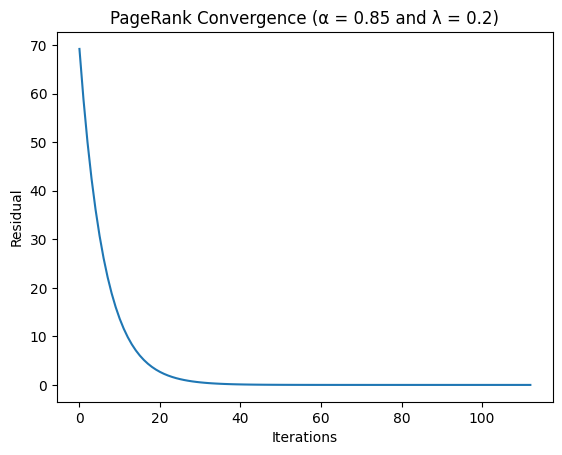


Top 10 papers by Temporal PageRank (alpha = 0.85 and λ = 0.2):
arXiv:17 (2017) - Attention is All you Need... | Score: 93.4669
2e9d221c (1997) - Long Short-Term Memory... | Score: 46.1276
6471fd1c (2013) - Generating Sequences With Recurrent Neural Networks... | Score: 16.6550
0b544dfe (2014) - Learning Phrase Representations using RNN Encoder–Decoder fo... | Score: 14.3250
0b44fcbe (1993) - Building a Large Annotated Corpus of English: The Penn Treeb... | Score: 13.1514
2c03df8b (2015) - Deep Residual Learning for Image Recognition... | Score: 12.6898
cea967b5 (2014) - Sequence to Sequence Learning with Neural Networks... | Score: 12.3445
fa72afa9 (2014) - Neural Machine Translation by Jointly Learning to Align and ... | Score: 11.5925
2e5f2b57 (2001) - Gradient Flow in Recurrent Nets: the Difficulty of Learning ... | Score: 9.4848
a6cb3667 (2014) - Adam: A Method for Stochastic Optimization... | Score: 7.9712


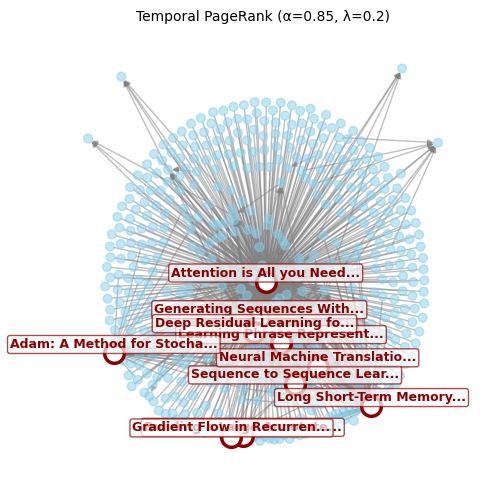

In [93]:
PR_temporal = Analysis_Temporal(G,0.85,0.2)

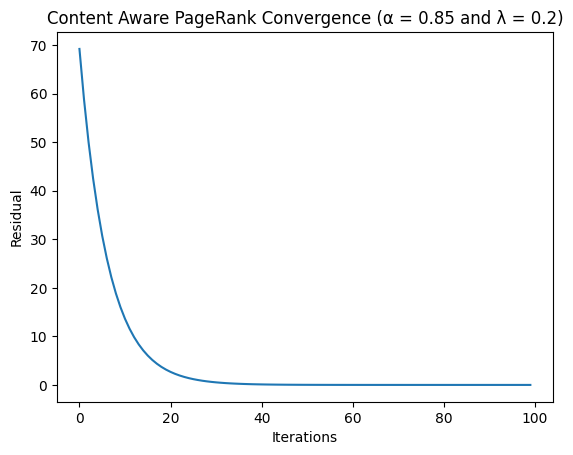


Top 10 papers by Content Aware Temporal PageRank (alpha = 0.85 and λ = 0.2):
arXiv:17 (2017) - Attention is All you Need... | Score: 52.3396
0b544dfe (2014) - Learning Phrase Representations using RNN Encoder–Decoder fo... | Score: 23.7822
fa72afa9 (2014) - Neural Machine Translation by Jointly Learning to Align and ... | Score: 21.2708
cea967b5 (2014) - Sequence to Sequence Learning with Neural Networks... | Score: 17.8115
6471fd1c (2013) - Generating Sequences With Recurrent Neural Networks... | Score: 13.4153
93499a7c (2015) - Effective Approaches to Attention-based Neural Machine Trans... | Score: 7.7881
2c03df8b (2015) - Deep Residual Learning for Image Recognition... | Score: 5.7616
b60abe57 (2016) - Deep Recurrent Models with Fast-Forward Connections for Neur... | Score: 5.1458
1518039b (2015) - Neural Machine Translation of Rare Words with Subword Units... | Score: 4.1746
c6850869 (2016) - Google's Neural Machine Translation System: Bridging the Gap... | Score: 4.1041


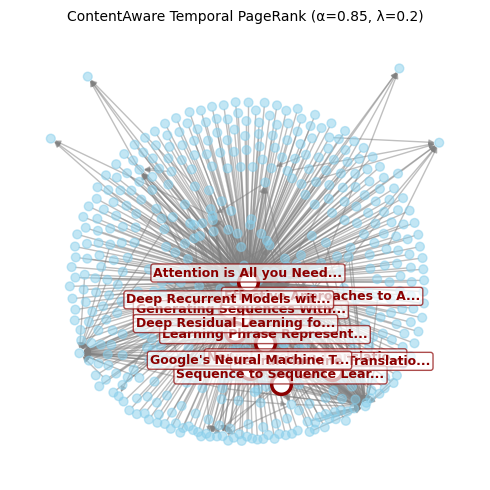

In [94]:
PR_Content_Aware = Analysis_ContentAware(G,0.85,0.2)

##### Comparison of Temporal and Content Aware Page Rank 

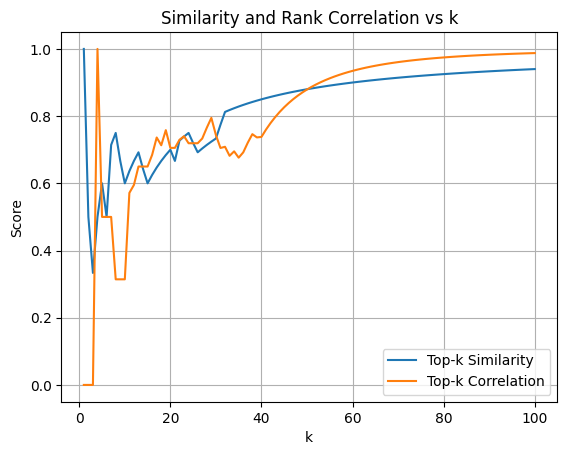

In [95]:
def topk_similarity(PR1, PR2, k):
    top1 = [pid for pid, _ in sorted(PR1.items(), key=lambda x: x[1], reverse=True)[:k]]
    top2 = [pid for pid, _ in sorted(PR2.items(), key=lambda x: x[1], reverse=True)[:k]]
    return len(set(top1) & set(top2)) / k

def topk_correlation(PR1, PR2, k):
    top1 = [pid for pid, _ in sorted(PR1.items(), key=lambda x: x[1], reverse=True)[:k]]
    top2 = [pid for pid, _ in sorted(PR2.items(), key=lambda x: x[1], reverse=True)[:k]]
    
    common = list(set(top1) & set(top2))
    if len(common) < 2:
        return 0.0
    
    r1 = {pid: rank for rank, pid in enumerate(top1)}
    r2 = {pid: rank for rank, pid in enumerate(top2)}
    
    ranks1 = [r1[pid] for pid in common]
    ranks2 = [r2[pid] for pid in common]
    
    return spearmanr(ranks1, ranks2).correlation

K = range(1, 101)

similarity = [topk_similarity(PR_temporal, PR_Content_Aware, k) for k in K]
correlation = [topk_correlation(PR_temporal, PR_Content_Aware, k) for k in K]

plt.figure()
plt.plot(K, similarity, label="Top-k Similarity")
plt.plot(K, correlation, label="Top-k Correlation")
plt.xlabel("k")
plt.ylabel("Score")
plt.title("Similarity and Rank Correlation vs k")
plt.legend()
plt.grid(True)
plt.show()

In [96]:
def Venue_Rank_Analysis(G, papers_df, tfidf_matrix, id_to_idx, PR_scores):
    print("Venue Ranking Analysis (Weighted Transfer)\n")
    
    # Group Papers by Venue
    venue_indices = {}
    for idx, row in papers_df.iterrows():
        venue = str(row['venue']).strip()
        if venue.lower() in ['nan', 'unknown', '']: 
            continue
        if venue not in venue_indices: 
            venue_indices[venue] = []
        venue_indices[venue].append(idx)

    # Common Keywords in Vneue & Transfer Weights
    venue_scores = {}
    print(f"Analyzing {len(venue_indices)} venues...")
    
    for venue, indices in venue_indices.items():
        # Venue Common Keywords
        vectors = tfidf_matrix[indices]
        common_keywords = np.asarray(np.mean(vectors, axis=0))
        
        total_score = 0.0
        for idx in indices:
            # Similarity
            paper_vec = tfidf_matrix[idx].toarray()
            sim = cosine_similarity(paper_vec, common_keywords)[0][0]
            
            pid = str(papers_df.iloc[idx]['paper_id'])
            rank = PR_scores.get(pid, 0.0)
            effective_rank = math.log(1.0 + rank)
            total_score += effective_rank * sim
            
        venue_scores[venue] = total_score / len(indices)
    
    sorted_venues = sorted(venue_scores.items(), key=lambda x: x[1], reverse=True)
    print("\nTop Venues (Ranked by Paper Relevance & Importance):")
    print(f"{'Rank':<5} | {'Score':<10} | {'Venue Name'}")
    print("-" * 60)
    for i, (v, s) in enumerate(sorted_venues[:15]):
        print(f"{i+1:<5} | {s:.6f}   | {v}")

PR, diffs , iter = ContentAware_PageRank(G,damping_factor=0.85,temporal_decay=0.2)
Venue_Rank_Analysis(G,papers_df, tfidf_matrix, id_to_idx, PR)

Venue Ranking Analysis (Weighted Transfer)

Analyzing 146 venues...

Top Venues (Ranked by Paper Relevance & Importance):
Rank  | Score      | Venue Name
------------------------------------------------------------
1     | 1.815776   | Transactions of the Association for Computational Linguistics
2     | 1.259686   | International Conference on Machine Learning
3     | 1.158934   | Neural Information Processing Systems
4     | 1.068429   | Conference of the European Chapter of the Association for Computational Linguistics
5     | 0.994375   | North American Chapter of the Association for Computational Linguistics
6     | 0.926677   | Conference on Empirical Methods in Natural Language Processing
7     | 0.802875   | Computer Vision and Pattern Recognition
8     | 0.644159   | arXiv.org
9     | 0.618349   | Annual Meeting of the Association for Computational Linguistics
10    | 0.513084   | International Conference on Learning Representations
11    | 0.434829   | Advances in Science and